# Bringing it all together: ERA5 and WRF

We want to compare ERA5 (aka the real world) with our outputs from WRF (aka the simulated world) for the 2 weeks of *Tropical Cyclone Gabrielle*.

## Objectives

- Combining everything you have learned so far:
    - loading satellite images
    - loading ERA5 data
    - loading WRF outputs
    - making maps
    - georeferencing data

## Tropical Cyclone Gabrielle
![](https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150972/cyclonegabrielle_vir_2023045.jpg)
- [link to article](https://earthobservatory.nasa.gov/images/150972/cyclone-gabrielle-lashes-new-zealand)
- [Modis/Aqua Corrected Reflectance](https://worldview.earthdata.nasa.gov/?v=-106.453125,-133.3125,321.328125,117&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor,MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=false&t=2023-02-17-T23%3A25%3A50Z)

In [1]:
# for numerics
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean as cmo
# import cmocean.cm as cm

# for loading files
import xarray as xr
import rasterio as rio

# formap projections
import cartopy.crs as ccrs

# setting this path so we have to type less
# PATH = "/nesi/nobackup/nesi99991/ASP_winterschool2023"
PATH = "../"

%load_ext watermark

In [2]:
date_ = "2023-02-14"
time_stamp = f"{date_}T00:00:00"

fnm_wrf = PATH+f"/WRF_exercises/outputs/control/wrfout_d01_{date_}_00:00:00"

## Load satellite image

In [3]:
src = rio.open(PATH+f"/data/satellite/snapshot-{date_}T00_00_00Z_1km.tiff")
img = src.read()
print(img.shape)
img = img.transpose(1,2,0) # -> shape=(H,W,3).
# plt.imshow(img) 
# plt.title(date_)
# plt.axis("off");
print(src.bounds)
img_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

(3, 6400, 6400)
BoundingBox(left=144.7031, bottom=-60.1787109375, right=200.9531, top=-3.9287109375)


Text(178.05, -38.8, 'Gisborne')

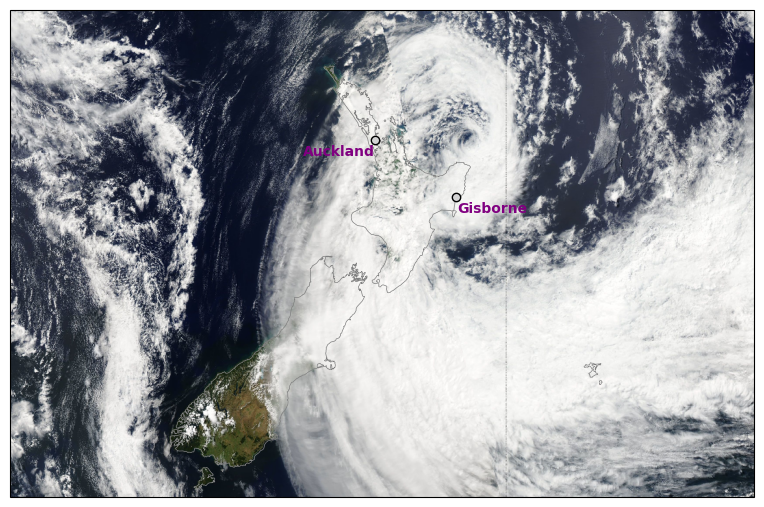

In [4]:
fig, ax = plt.subplots(1,1,subplot_kw={"projection": ccrs.epsg(3832)}, figsize=(9.6,6.4))
ax.coastlines(lw=0.5,color='grey')
nz_extent = [160,190,-47.5,-32.5]
ax.set_extent(nz_extent)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
# mark a known place to help us geo-locate ourselves
ax.plot(174.73, -36.84, ls='', marker='o', mec='k', color='lightgrey', markersize=6, transform=ccrs.Geodetic())
ax.text(174.7, -37, 'Auckland', color='purple', fontweight="bold", va='top', ha='right', transform=ccrs.Geodetic())
ax.plot(178, -38.65, ls='', marker='o', mec='k', color='lightgrey', markersize=6, transform=ccrs.Geodetic());
ax.text(178.05, -38.8, 'Gisborne', color='purple', fontweight="bold", va='top', ha='left', transform=ccrs.Geodetic())

## Load ERA-5 data

In [5]:
fnm = PATH+"/data/era5.nc"
ds_era5 = xr.open_dataset(fnm)
ds_era5["wind10"] = (ds_era5["u10"]**2+ds_era5["v10"]**2)**0.5
ds_era5

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 408, longitude: 281, latitude: 301)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-02-02 ... 2023-02-18T23:00:00
  * longitude  (longitude) float32 1kB 145.0 145.2 145.5 ... 214.5 214.8 215.0
  * latitude   (latitude) float32 1kB 15.0 14.75 14.5 ... -59.5 -59.75 -60.0
Data variables:
    u10        (time, latitude, longitude) float64 276MB -9.949 -9.805 ... 7.145
    v10        (time, latitude, longitude) float64 276MB -1.461 -1.231 ... 5.882
    t2m        (time, latitude, longitude) float64 276MB ...
    msl        (time, latitude, longitude) float64 276MB ...
    ro         (time, latitude, longitude) float64 276MB ...
    sst        (time, latitude, longitude) float64 276MB ...
    tcc        (time, latitude, longitude) float64 276MB ...
    tclw       (time, latitude, longitude) float64 276MB ...
    tp         (time, latitude, longitude) float64 276MB ...
    wind10     (time, latitude, longitude) float64 276MB 10.06 9.882 ... 9.255
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Jul 29 01:21:08 2023: cdo -sellonlatbox,145,215,-60,15 ...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

## Overlay precipitation data from ERA5

- `tp` is total precipitation
- We want to ignore values smaller than 1mm per hour

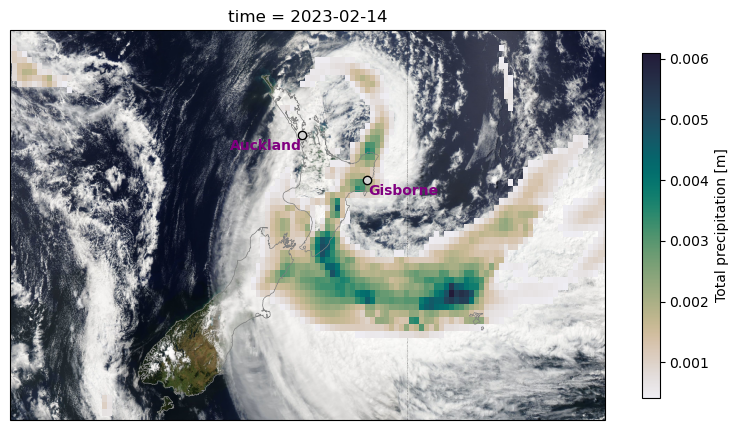

In [6]:
era5_sub = ds_era5.sel(time=time_stamp).sel(longitude=slice(160-1,190+1),latitude=slice(-32.5+1,-47.5-1))
era5_sub = era5_sub.where(era5_sub["tp"]>0.01/24) # cut off for too small values

era5_sub["tp"].plot(ax=ax,x="longitude",y="latitude",
                    transform=ccrs.PlateCarree(),
                    cmap=cmo.cm.rain,
                    cbar_kwargs={"shrink": 0.7})

fig

## Overlay wind vectors from ERA5

- [`quiver`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) for vectors

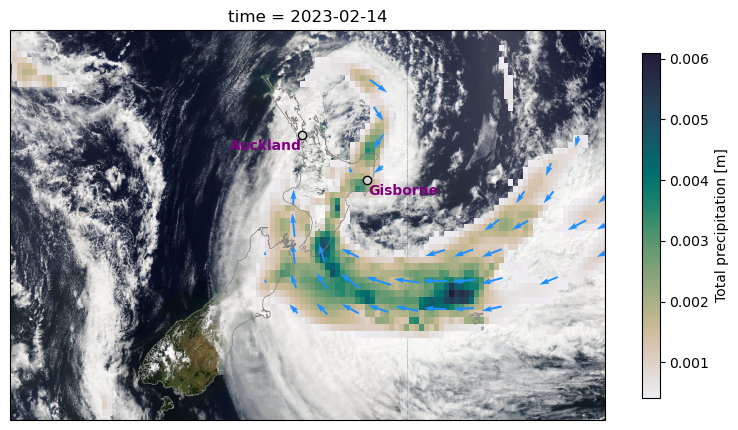

In [7]:
x = era5_sub.longitude.values
y = era5_sub.latitude.values
u = era5_sub.u10.values
v = era5_sub.v10.values

Q = ax.quiver(x, y, u, v, color='dodgerblue', pivot='middle', transform=ccrs.PlateCarree(), regrid_shape=15)

# vel = 20.0
# qk = ax.quiverkey(Q, 
#                    0.9, 1.05,                  # x,y label position
#                    vel, str(int(vel))+' '+r'$m\,s^{-1}$', # choose units + update string
#                    labelpos='W',                # add label to the right
#                    coordinates='axes', color='dodgerblue',
#                    )
fig

**Exercises**

1. Save the figure as a PNG file
2. Pick another date and repeat
3. Pick another variable to overlay, for example, wind speed $> 10\,m\,s^{-1}$

## Open WRF output

- This time, we are using `wrf`, a Python library specific for processing of WRF variables ([docs](https://wrf-python.readthedocs.io/en/latest/))

In [8]:
# for WRF processing
import wrf as wrf
import netCDF4 as nc4

In [9]:
# Open the NetCDF file
ncfile = nc4.Dataset(fnm_wrf)

cen_lat, cen_lon = ncfile.CEN_LAT, ncfile.CEN_LON
truelat1, truelat2, STAND_LON = ncfile.TRUELAT1, ncfile.TRUELAT2, ncfile.STAND_LON
pole_lat, pole_lon = ncfile.POLE_LAT, ncfile.POLE_LON

t = 0
# Get the dbz, t2, slp, u10, v10, pw
dbz = wrf.getvar(ncfile, "dbz", timeidx=t)
slp  = wrf.getvar(ncfile, "slp", timeidx=t)
t2  = wrf.getvar(ncfile, "T2", timeidx=t)
pw  = wrf.getvar(ncfile, "pw", timeidx=t)
u10 = wrf.getvar(ncfile, "U10", timeidx=t)
v10 = wrf.getvar(ncfile, "V10", timeidx=t)

ncfile.close()

# transform wind vectors into north-south basis
cone = 1.0
uv   = wrf.uvmet(u10, v10, u10.XLONG, u10.XLAT, cen_lon, cone, meta=True, units='m s-1')

# Get the latitude and longitude points
lats, lons = wrf.latlon_coords(t2)

# Get the cartopy mapping object
wrf_proj = wrf.get_cartopy(t2)
print(wrf_proj.to_string())
wrf_proj

+proj=ob_tran +a=6370000.0 +b=6370000.0 +nadgrids=@null +o_proj=latlon +o_lon_p=-141.3800048828125 +o_lat_p=-60.310001 +lon_0=147.6300010681152 +to_meter=111177.4733520388 +no_defs +type=crs


<Bound CRS: +proj=ob_tran +a=6370000.0 +b=6370000.0 +nadgrids= ...>
Name: unnamed
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed to WGS84
- method: NTv2
Datum: unknown using nadgrids=@null
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unnamed

(279, 229)


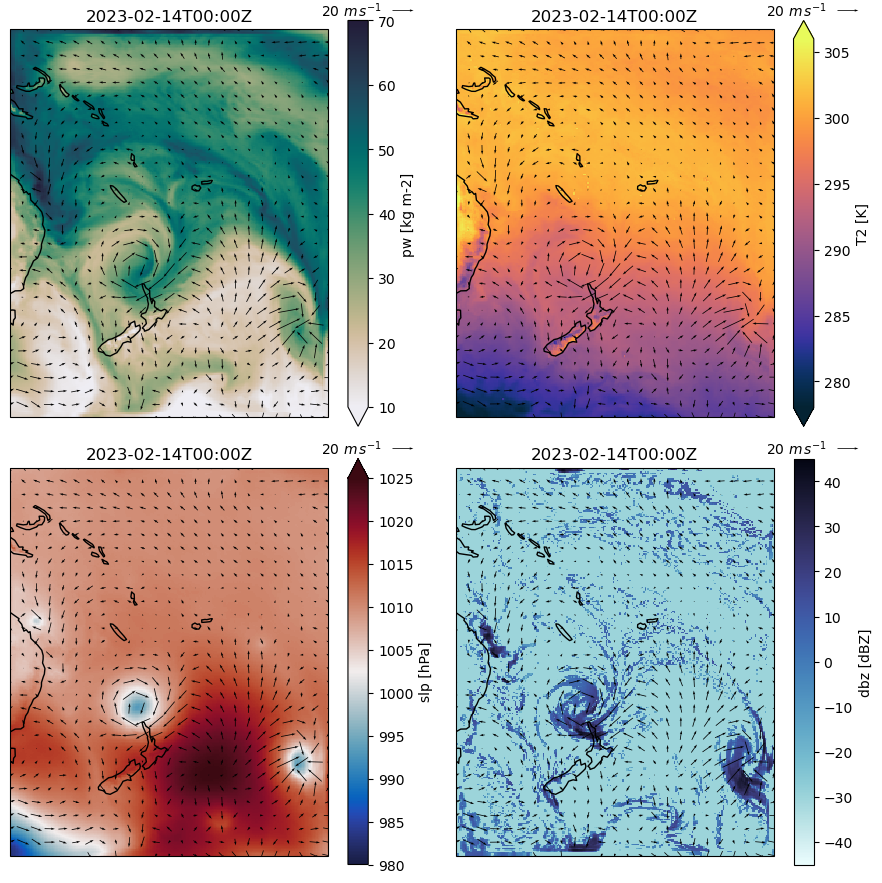

In [10]:
data_proj = ccrs.PlateCarree()

fig, axes = plt.subplots(2, 2,
                         figsize=(9,9),
                         subplot_kw={'projection': wrf_proj},
                         sharex=True, sharey=True)
axes = axes.flatten()

# precitable water
pw.plot(ax=axes[0], x='XLONG', y='XLAT', cmap=cmo.cm.rain,
        vmin = 10, vmax = 70,
    transform=data_proj
)

t2.plot(ax=axes[1], x='XLONG', y='XLAT', cmap=cmo.cm.thermal,
        vmin = 278, vmax = 306,
    transform=data_proj
)

slp.plot(ax=axes[2], x='XLONG', y='XLAT', cmap=cmo.cm.balance,
        vmin = 980, vmax = 1025,
    transform=data_proj
)

dbz[0,...].plot(ax=axes[3], x='XLONG', y='XLAT', cmap=cmo.cm.ice_r,
        vmin = -45, vmax = 45,
    transform=data_proj
)

x = u10.XLONG.values
y = u10.XLAT.values
u = uv[0].values
v = uv[1].values
print(x.shape)
# time = u10.Time.values
time = np.datetime_as_string(u10.Time.values, timezone='UTC', unit="m")
for ax in axes:
    # Add wind vectors
    Q = ax.quiver( x, y, u, v, color='k', pivot='middle', transform=data_proj, regrid_shape=25)

    ax.set_title(time)
    ax.coastlines()
    ax.set_xlim(wrf.cartopy_xlim(t2))
    ax.set_ylim(wrf.cartopy_ylim(t2))
    
    vel = 20.0
    qk = ax.quiverkey(Q, 
                       1.2, 1.05,                  # x,y label position
                       vel, str(int(vel))+' '+r'$m\,s^{-1}$', # choose units + update string
                       labelpos='W',                # add label to the right
                       coordinates='axes', color='k',
                       )
fig.tight_layout()

**Exercises and Questions**

1. Save the panel plots as PNG file
2. Compare the WRF model results for this specific date with ERA5. What do you observe?
3. Recreate the same panel for an earlier date, say 5 Feb, and go back to the previous question.
4. Recreate the same panel with your alternative model run. What is different? Why?

In [11]:
%watermark
%watermark --iversions

Last updated: 2024-08-21T12:11:23.174844+12:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

numpy     : 1.26.4
wrf       : 1.3.4.1
netCDF4   : 1.7.1
cmocean   : 4.0.3
matplotlib: 3.9.2
xarray    : 2024.7.0
cartopy   : 0.23.0
rasterio  : 1.3.10

